# Peak Fitting in Synthetic XRD-CT Datasets

## 📝 Introduction

In this notebook, we explore **peak-based analysis** of synthetic XRD-CT datasets generated using the `nDTomo` package. Having already performed unsupervised analysis (e.g. PCA, NMF, clustering) on this dataset, we now focus on **quantitative extraction of diffraction peak parameters**, which is essential in many real-world applications of XRD-CT.

This step mimics the **final stage of XRD-CT data analysis**, where we move beyond general pattern recognition and into **parametric modelling of Bragg reflections** — enabling phase quantification, strain mapping, and microstructural analysis.

## 🎯 Objectives

By the end of this notebook, you will:
- Re-use the synthetic phantom XRD-CT dataset generated previously
- Perform background subtraction and identify key peaks
- Fit diffraction patterns using both single-peak and multi-peak models
- Generate 2D chemical maps based on extracted peak intensities, positions, or FWHM
- Evaluate the effectiveness of peak fitting on clean, controlled data

## 🧪 Why Peak Fitting?

While clustering and unmixing methods can reveal overall trends, **peak fitting allows you to extract phase-specific parameters** with physical meaning:

- **Peak position** → Lattice parameter / strain
- **Peak area** → Phase abundance
- **Peak width** → Crystallite size or microstrain (via Scherrer or Williamson-Hall)

These metrics are especially valuable in:
- Operando catalyst studies
- Battery material evolution
- Polymorphism detection
- Crystallinity and size analysis

Even in synthetic datasets, peak fitting provides a crucial benchmark to test the limits of resolution and accuracy.

## 📦 Dataset

We will re-use the same synthetic phantom XRD-CT dataset created earlier:

- 5 chemical components (Al, Cu, Fe, Pt, Zn)
- 2D spatial images for each component
- Simulated diffraction patterns for each pixel

The volume has shape:

$$
(x, y, q) = (200, 200, 250)
$$

where $q$ is the diffraction axis (e.g., $2\theta$ or $q$-space).

We now begin by importing the relevant packages and loading the synthetic volume.

## 🧪 Generate the Synthetic XRD-CT Phantom

Before we begin fitting diffraction peaks, we must first simulate a synthetic chemical tomography dataset using `nDTomo`. This dataset mimics the type of data produced in real XRD-CT experiments, where each pixel contains a full diffraction pattern (rather than a single intensity value).

We simulate 5 chemical components (Al, Cu, Fe, Pt, Zn), each defined by:
- A **reference diffraction pattern** (1D)
- A **2D spatial image** showing where the phase is located

These are linearly combined into a 3D dataset of shape $(x, y, q)$, where each spatial pixel has its own composite diffraction pattern.

### 📥 Load Spectra and Spatial Maps

We begin by importing the simulated diffraction patterns and the corresponding phantom images.

Next we generate a 3D synthetic XRD-CT volume by assigning spectra to spatial regions. Each pixel's diffraction pattern is a weighted sum of the reference patterns based on the phase distribution images.


<KeysViewHDF5 ['Al', 'Cu', 'Fe', 'Pt', 'Zn', 'q', 'tth']>


/home/antonyvam/anaconda3/envs/ndtomo/lib/python3.8/site-packages/xdesign/geometry/area.py:789: UserWarning: Didn't check that Mesh contains Circle.
  warnings.warn("Didn't check that Mesh contains Circle.")


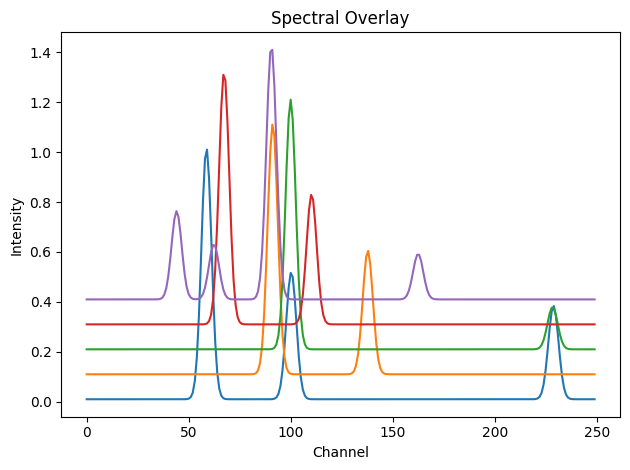

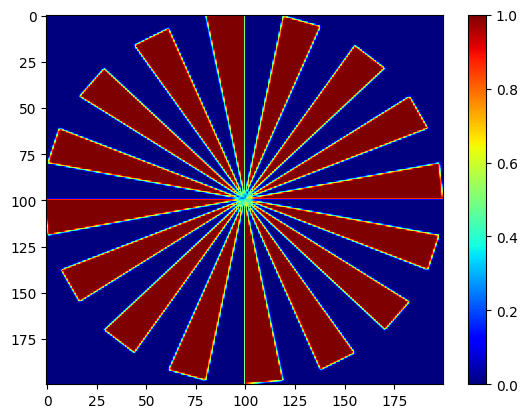

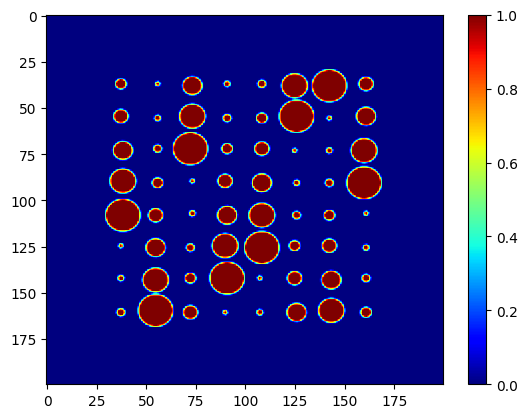

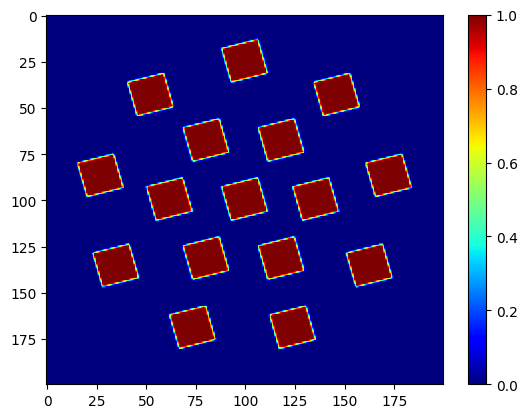

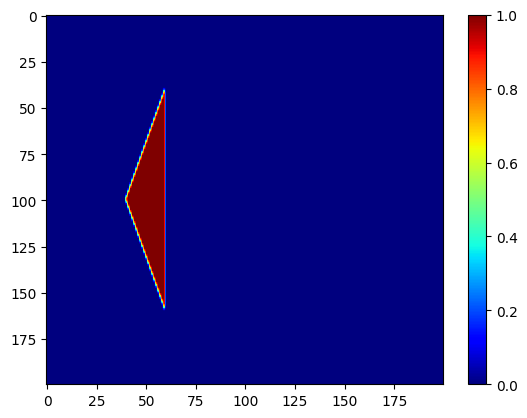

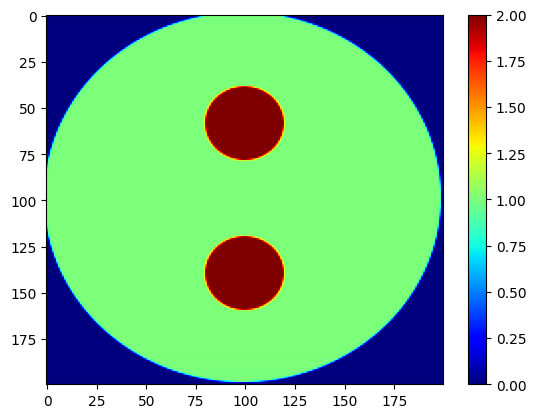

100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

Phantom volume shape: (200, 200, 250)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim

# Load five example diffraction patterns
dpAl, dpCu, dpFe, dpPt, dpZn, tth, q = load_example_patterns()
spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]

# Create 2D spatial images for the five components
npix = 200
imAl, imCu, imFe, imPt, imZn = nDTomophantom_2D(npix, nim='Multiple')
iml = [imAl, imCu, imFe, imPt, imZn]

# Visualise spectra with vertical offsets
showspectra([dpAl, dpCu + 0.1, dpFe + 0.2, dpPt + 0.3, dpZn + 0.4], fig_num=1)

# Optionally display spatial maps
showim(imAl, 2)
showim(imCu, 3)
showim(imFe, 4)
showim(imPt, 5)
showim(imZn, 6)

chemct = nDTomophantom_3D(npix, use_spectra='Yes', spectra=spectra, imgs=iml, indices='All', norm='No')
print("Phantom volume shape:", chemct.shape)

We can now interactively explore the spectral content of this volume using the chemimexplorer

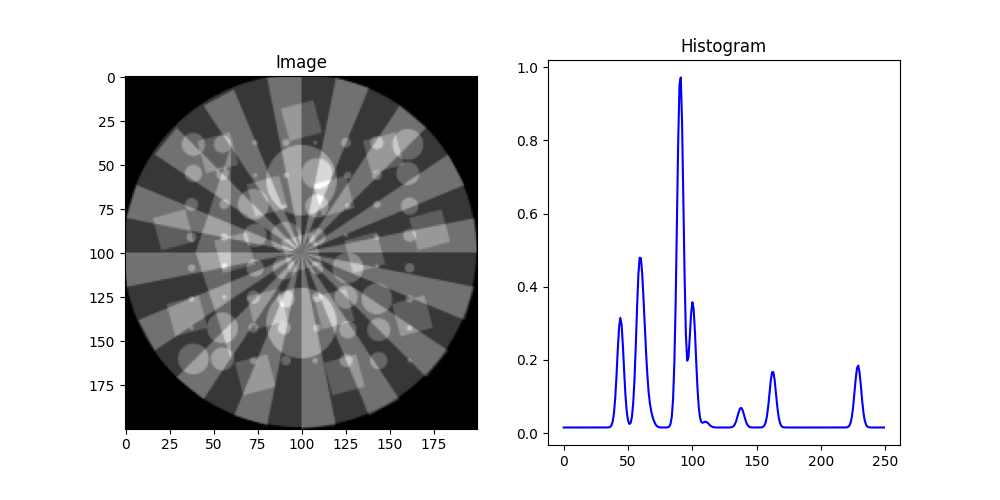

In [2]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(chemct)

Let’s examine the mean diffraction pattern across the entire sample. This helps identify regions for peak fitting.

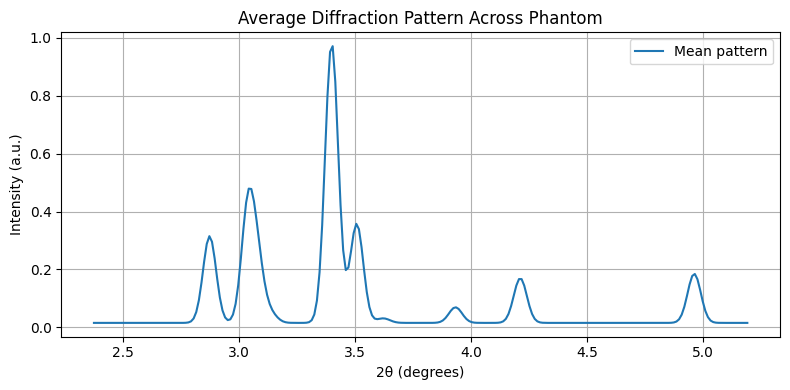

In [5]:
%matplotlib inline

mean_pattern = chemct.mean(axis=(0, 1))

plt.figure(figsize=(8,4))
plt.plot(tth, mean_pattern, label='Mean pattern')
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity (a.u.)")
plt.title("Average Diffraction Pattern Across Phantom")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 🔎 Select a Peak Region and Subtract Background

In order to perform peak fitting, we first need to define a **region of interest (ROI)** in the diffraction pattern that contains one or more peaks. This region should be:

- Representative of a specific phase or reflection
- Well separated from neighbouring peaks (for single-peak fitting)
- Consistent across the entire dataset

In this synthetic dataset, the peaks are clean and well-behaved, so we can manually select a region based on the 2θ axis.

### 🔧 Step 1: Define ROI

Inspecting the average pattern, we select a window in 2θ that contains a prominent peak. For example:


In [6]:
# Define 2θ limits for a peak region
roi_min = 2.7
roi_max = 2.95

# Find indices corresponding to this 2θ range
roi_mask = (tth >= roi_min) & (tth <= roi_max)
roi_indices = np.where(roi_mask)[0]

# Extract the corresponding 2θ axis for this window
tth_roi = tth[roi_mask]

We now extract the peak region for every pixel in the dataset, reducing the 3D volume from shape $(x, y, tth)$ to $(x, y, tth_{\text{roi}})$.

In [7]:
# Extract region of interest from each pixel
chemct_roi = chemct[:, :, roi_mask]

# Confirm new shape
print("ROI volume shape:", chemct_roi.shape)

ROI volume shape: (200, 200, 22)


A basic background model can be fitted as a straight line using the first and last points in each spectrum. We subtract this line from the data to isolate the peak shape.

In [8]:
def subtract_linear_background(data_roi):
    """
    Subtracts a linear background from the last axis of a 3D array.
    Background is defined using the first and last points in each spectrum.
    """
    x1 = tth_roi[0]
    x2 = tth_roi[-1]
    
    y1 = data_roi[:, :, 0]
    y2 = data_roi[:, :, -1]
    
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1

    background = slope[..., None] * tth_roi + intercept[..., None]
    return data_roi - background

# Apply background subtraction
chemct_roi_bgsub = subtract_linear_background(chemct_roi)

To validate the background subtraction, we plot a single pixel’s spectrum before and after processing.

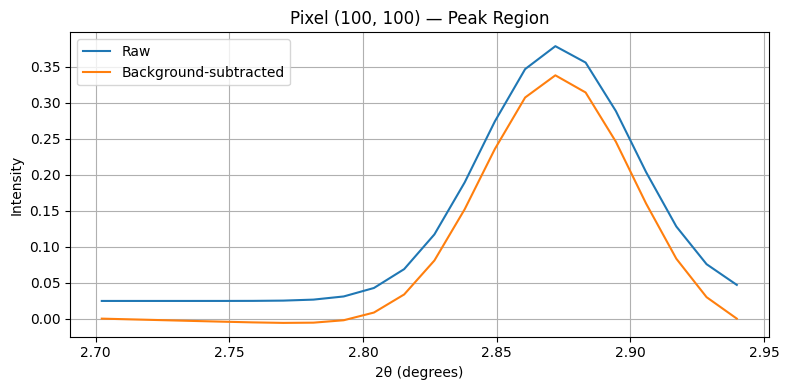

In [9]:
# Choose a pixel location
ix, iy = 100, 100

raw = chemct_roi[ix, iy, :]
bgsub = chemct_roi_bgsub[ix, iy, :]

plt.figure(figsize=(8,4))
plt.plot(tth_roi, raw, label='Raw')
plt.plot(tth_roi, bgsub, label='Background-subtracted')
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity")
plt.title(f"Pixel ({ix}, {iy}) — Peak Region")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔧 Fit a Gaussian Peak at Every Pixel

We now fit a **Gaussian peak** to the background-subtracted data at each pixel within the region of interest (ROI). The Gaussian model is defined as:

$$
I(tth) = A \cdot \exp\left( -\frac{(tth - \mu)^2}{2\sigma^2} \right)
$$

Where:
- $A$ is the **peak amplitude** (height)
- $\mu$ is the **peak position** ($2θ$)
- $\sigma$ is related to the **peak width** (standard deviation)

From the fitted parameters, we can also compute:
- **FWHM** (Full Width at Half Maximum): $ \text{FWHM} = 2\sqrt{2\ln 2} \cdot \sigma \approx 2.355 \cdot \sigma $

---

### ⚙️ Fit Function (Gaussian)

We define a Gaussian model and a fitting wrapper using `scipy.optimize.curve_fit`.


In [10]:
from scipy.optimize import curve_fit

# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

To keep things simple and fast, we’ll iterate over a subset of pixels and store the fitted parameters: A, mu, and sigma.

In [14]:
nx, ny, nq_roi = chemct_roi_bgsub.shape
params = np.zeros((nx, ny, 3))  # A, mu, sigma

# Fitting bounds (optional)
bounds = ([0, tth_roi[0], 0.01], [np.inf, tth_roi[-1], 1.0])

# Loop over all pixels (or a cropped subset for speed)
for ix in tqdm(range(nx)):
    for iy in range(ny):
        y = chemct_roi_bgsub[ix, iy, :]
        
        # Skip pixels with very low signal
        if y.max() < 1e-3:
            continue
        
        # Initial guess: [amplitude, position, width]
        guess = [y.max(), tth_roi[np.argmax(y)], 0.1]
        
        try:
            popt, _ = curve_fit(gaussian, tth_roi, y, p0=guess, bounds=bounds)
            params[ix, iy, :] = popt
        except RuntimeError:
            pass  # Fit failed

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:20<00:00,  1.42it/s]


We now plot the resulting maps for:

Peak amplitude (intensity)

Peak position (2θ)

Peak FWHM

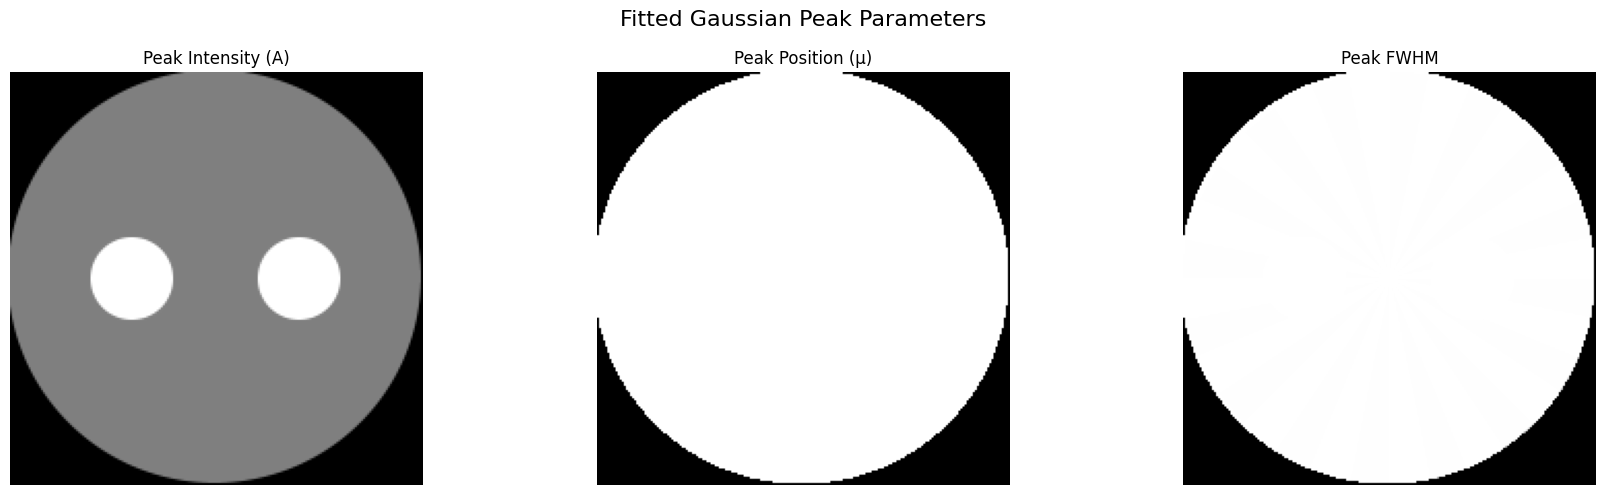

In [16]:
A_map = params[:, :, 0]
mu_map = params[:, :, 1]
sigma_map = params[:, :, 2]
fwhm_map = 2.355 * sigma_map

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(A_map, cmap='gray')
axs[0].set_title("Peak Intensity (A)")
axs[0].axis('off')

axs[1].imshow(mu_map, cmap='gray')
axs[1].set_title("Peak Position (μ)")
axs[1].axis('off')

axs[2].imshow(fwhm_map, cmap='gray')
axs[2].set_title("Peak FWHM")
axs[2].axis('off')

plt.suptitle("Fitted Gaussian Peak Parameters", fontsize=16)
plt.tight_layout()
plt.show()

## 🧠 Discussion

In this notebook, we implemented a full pipeline for **single-peak fitting** on a synthetic XRD-CT dataset generated with `nDTomo`. This process, from selecting a region of interest, subtracting background, and fitting a Gaussian model, mirrors what is routinely done in experimental diffraction tomography analysis.

While the data used here is noise-free and idealised, the fitting procedure allows us to reflect on both the **value** and the **limitations** of peak-based modelling in chemical imaging.

### ✅ Strengths of Peak Fitting

- **Interpretability**: Fitted parameters such as intensity, peak position, and FWHM are physically meaningful. They relate directly to crystallographic properties like phase abundance, lattice strain, or crystallite size.
- **Component-level quantification**: Unlike statistical methods (e.g. PCA), peak fitting allows us to isolate signals tied to specific reflections or phases.
- **Pixel-wise analysis**: Peak parameters can be mapped spatially, giving high-resolution insight into microstructural variations.

### ⚠️ Limitations and Assumptions

- **Assumes peak shapes are well known**: Here we used a Gaussian, but real data often requires pseudo-Voigt, split-Voigt, or asymmetric models.
- **Highly dependent on background modelling**: Linear subtraction works well in clean data, but poorly modelled backgrounds can lead to erroneous fits.
- **Ignores overlapping peaks**: In cases with multiple nearby reflections, single-peak models may misassign intensity or bias position/FWHM.
- **Sensitive to initial guess and bounds**: Even with good data, non-linear fitting can fail or converge to local minima if not well conditioned.

### 🧪 What This Synthetic Case Tells Us

Working with synthetic data allows us to benchmark the method in an environment where the "ground truth" is known. In this notebook, we demonstrated that:

- Gaussian peak fitting recovers realistic amplitude and position maps for a clean, isolated peak.
- The spatial distribution of fitted parameters corresponds closely to the original phantom images used to generate the dataset.
- Even in the absence of noise, robust fitting requires thoughtful background subtraction and well-chosen peak regions.

### 🐢 Performance Considerations and the Need for Acceleration

Despite fitting only a **single peak** across a relatively small $(200 \times 200)$ pixel dataset, the process was **computationally slow** — primarily due to pixel-wise non-linear optimisation.

This highlights a major challenge in modern XRD-CT analysis:

> As synchrotron upgrades and detector advancements dramatically increase the volume and resolution of chemical imaging datasets, traditional CPU-based peak fitting becomes a bottleneck.

For larger datasets (e.g. full tomographic time series, multi-phase systems, or high-resolution 3D scans), performing **multi-peak or full-pattern fitting** becomes prohibitively slow.

There is now a clear and urgent need to adopt **GPU-accelerated peak fitting** frameworks that can:
- Exploit pixel-wise parallelism
- Handle complex models (e.g. pseudo-Voigt mixtures, constrained fitting)
- Scale to millions of spectra

Such developments are key to unlocking **real-time analysis** and **high-throughput experimentation** at beamlines.

### 🎯 Final Remarks

Peak fitting is often the **last step in the XRD-CT analysis pipeline**, where physics-based modelling takes over from data-driven pattern recognition. When done carefully, it offers detailed, quantitative insight into material behaviour.

This tutorial provides a clean baseline implementation that can be extended and adapted to your own datasets, synthetic or experimental, while also highlighting the performance limitations that motivate GPU-based solutions for the next generation of chemical imaging.

Happy fitting!